<a href="https://colab.research.google.com/github/sonuuno2020/Para-Classifier/blob/main/ParaClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Purpose : To classify a paragraph into multiple sections for simpler and better understanding**

```
In this notebook, NLP model is based on medical text.

It is a multi-classification of text but it is Many-to-One problem.

Mainly it's a replication of PubMed200.
https://arxiv.org/pdf/1612.05251.pdf
https://arxiv.org/pdf/1710.06071.pdf

```

**GPU Access**

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-37be49db-db1b-3ac7-38af-96cd9fd24b3c)


## **Get Data**

* Get PubMed200 dataset publicly available

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.


In [ ]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


👀 Here we have 2 datasets - 100% data and 10% data

In [ ]:
!ls pubmed-rct/PubMed_20k_RCT
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign


dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
data_dir='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

## **Become One with Data**

In [ ]:
def get_lines(filename):
  """
    reads a text file and return all lines in a list.
  """

  with open (filename,'r') as file:
    return file.readlines()

In [ ]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 


⚡ Here our data is in list but ***input and label are in same sentence*** 

* so we have to **break (⛏) them down** 

* **seperate each instances (✂ )** 

* For this we need a **preprocessing** function.

In [ ]:
#@title structure


```
How to format our Data ❓

list of dictionaries.

[
  first Inst. --> {
                    label_1 : [
                                sentence_1,
                                sentence_12,
                                ...
                              ],

                    label_2 : [
                                sentence_3,
                                sentence_7,
                                ...
                              ]
                    and so on...
                  },
  -----------------------------------------------------------------------
  Second Inst. --> {
                    label_1 : [
                                sentence_1,
                                sentence_12,
                                ...
                              ],

                    label_2 : [
                                sentence_3,
                                sentence_7,
                                ...
                              ]
                    and so on...
                  },
  ---------------------------------------------------------------------

  and so on..
]
```

SyntaxError: ignored

In [ ]:
# here we are going to write a preprcessing function to do so...

def preprocessing_text_with_line_number(filename):
  """
    Takes a filename and extract all lines then make a list of dictionaries,
    For each instance each one contains :
        line_number
        target
        text
        total_lines = number of lines in each paragraph
  """

  input_lines = get_lines(data_dir + filename)
  text_blog=""

  samples=[]

  for line in input_lines:

    if line.startswith('###'):
      id=line
      text_blog=""
    elif line.isspace():

      all_lines=text_blog.splitlines()

      for line_number,curr_line in enumerate(all_lines):
        temp=dict()
        temp['line_number']=line_number
        label,text=curr_line.split('\t')
        temp['target']=label
        temp['text']=text.lower()
        temp['total_lines']=len(all_lines)-1

        samples.append(temp)

    else:
      text_blog+=line 

  return samples 


  

In [ ]:
train_text=preprocessing_text_with_line_number('train.txt')
val_text=preprocessing_text_with_line_number('dev.txt')
test_text=preprocessing_text_with_line_number('test.txt')


In [ ]:
import pandas as pd

In [ ]:
train_df=pd.DataFrame(train_text)
val_df=pd.DataFrame(val_text)
test_df=pd.DataFrame(test_text)

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [ ]:
test_df.head()

,line_number,target,text,total_lines
0,0,BACKGROUND,this study analyzed liver function abnormaliti...,8
1,1,RESULTS,a post hoc analysis was conducted with the use...,8
2,2,RESULTS,liver function tests ( lfts ) were measured at...,8
3,3,RESULTS,survival analyses were used to assess the asso...,8
4,4,RESULTS,the percentage of patients with abnormal lfts ...,8


In [ ]:
val_df.head()

,line_number,target,text,total_lines
0,0,BACKGROUND,ige sensitization to aspergillus fumigatus and...,9
1,1,BACKGROUND,it is not clear whether these patients would b...,9
2,2,OBJECTIVE,we sought to determine whether a @-month cours...,9
3,3,METHODS,asthmatic patients who were ige sensitized to ...,9
4,4,METHODS,primary outcomes were improvement in quality o...,9


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

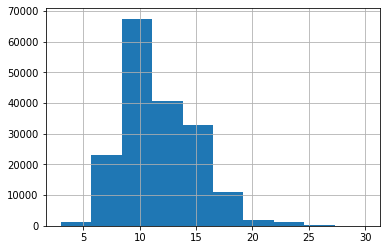

In [ ]:
train_df.total_lines.hist()

## **Convert text into numbers**

There are many ways to convert text into numbers.

* One Hot Encoder
* Label Encoder

In [ ]:
# OnehotEncoding 

from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))


In [ ]:
# LabelEncoding

from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()

train_label_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
test_label_encoded=label_encoder.transform(test_df['target'].to_numpy())
val_label_encoded=label_encoder.transform(val_df['target'].to_numpy())


In [ ]:
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
train_sentences=train_df['text']
test_sentences=test_df['text']
val_sentences=val_df['text']

## **Model 0 : Baseline model( TFidf )**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

In [ ]:
model_0=Pipeline([
    ('tfid',TfidfVectorizer()),
    ('clf',MultinomialNB())
])

In [ ]:
model_0.fit(train_sentences,train_label_encoded)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences,val_label_encoded)

0.7218323844829869

In [ ]:
# make a function to evaluate model experiments

from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score

def evaluate_model(y_true,y_preds):
  model_accuracy=accuracy_score(y_true,y_preds)
  model_recall=recall_score(y_true,y_preds,average='weighted')
  model_precision=precision_score(y_true,y_preds,average='weighted')
  model_f1=f1_score(y_true,y_preds,average='weighted')

  return {
      "accuracy":model_accuracy,
      "recall":model_recall,
      "precision":model_precision,
      "f1-score":model_f1
  }

In [ ]:
model_0_preds=model_0.predict(val_sentences)

In [ ]:
baseline_results=evaluate_model(y_preds=model_0_preds,y_true=val_label_encoded)
baseline_results

{'accuracy': 0.7218323844829869,
 'recall': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'f1-score': 0.6989250353450294}

## **Vectorization and Embedding**

In [ ]:
import numpy as np

In [ ]:
output_lens=[len(x.split()) for x in train_sentences]
np.mean(output_lens)

26.338269273494777

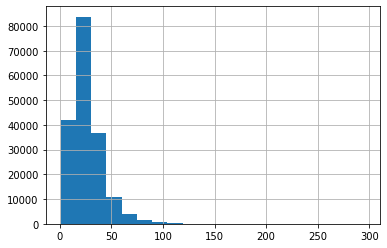

In [ ]:
train_sentences.map(lambda x : len(x.split())).hist(bins=20)

In [ ]:
output_seq_len=np.percentile(train_sentences.map(lambda x : len(x.split())),95)
output_seq_len

55.0

### vectorizer

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
max_vocab_length=68000
max_length=int(output_seq_len)
word_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode='int',
                                  output_sequence_length=max_length)

In [ ]:
word_vectorizer.adapt(train_sentences)

In [ ]:
word_vectorizer([val_sentences[911]])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[   8, 1941,    4,    1,   40,    3,    1,   40,  104,   10,  437,
          51,    6,  297,  361,  145,    6,   64,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
pub_20k_vocab=word_vectorizer.get_vocabulary()

In [ ]:
pub_20k_vocab[:10]

['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were']

In [ ]:
pub_20k_vocab[-10:]

['aarm',
 'aaqol',
 'aaq',
 'aanhui',
 'aana',
 'aainduced',
 'aaigroup',
 'aachener',
 'aachen',
 'aaacp']

In [ ]:
import tensorflow as tf

### Embedding

In [ ]:
word_embedding=tf.keras.layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    mask_zero=True,
    name='word_embedding'
)

In [ ]:
word_embedding(word_vectorizer([val_sentences[911]]))

<tf.Tensor: shape=(1, 55, 128), dtype=float32, numpy=
array([[[-0.0193478 ,  0.00350001, -0.04385153, ..., -0.04276624,
          0.00328431,  0.04873155],
        [ 0.03984113, -0.03593364,  0.00488651, ..., -0.01853736,
         -0.01104454,  0.04682556],
        [-0.03523695,  0.03002379, -0.02346654, ...,  0.02493064,
         -0.00495265, -0.01741431],
        ...,
        [-0.02605271, -0.01250907,  0.01466267, ...,  0.00848417,
          0.0162403 ,  0.0456066 ],
        [-0.02605271, -0.01250907,  0.01466267, ...,  0.00848417,
          0.0162403 ,  0.0456066 ],
        [-0.02605271, -0.01250907,  0.01466267, ...,  0.00848417,
          0.0162403 ,  0.0456066 ]]], dtype=float32)>

In [ ]:
idx=911

print("Actual sentence : ",val_sentences[idx])
print('\nlen of sentence : ',len(val_sentences[idx].split()))

print('\nAfter Vectorization\n')
print(word_vectorizer([val_sentences[idx]]))

print('\nAfter Embedding\n')
print(word_embedding(word_vectorizer([val_sentences[idx]])))

Actual sentence :  a subset of ush@ ( n = @ ) and ush@ ( n = @ ) subjects was examined two to four times over @ to @ years .

len of sentence :  29

After Vectorization

tf.Tensor(
[[   8 1941    4    1   40    3    1   40  104   10  437   51    6  297
   361  145    6   64    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(1, 55), dtype=int64)

After Embedding

tf.Tensor(
[[[-0.0193478   0.00350001 -0.04385153 ... -0.04276624  0.00328431
    0.04873155]
  [ 0.03984113 -0.03593364  0.00488651 ... -0.01853736 -0.01104454
    0.04682556]
  [-0.03523695  0.03002379 -0.02346654 ...  0.02493064 -0.00495265
   -0.01741431]
  ...
  [-0.02605271 -0.01250907  0.01466267 ...  0.00848417  0.0162403
    0.0456066 ]
  [-0.02605271 -0.01250907  0.01466267 ...  0.00848417  0.0162403
    0.0456066 ]
  [-0.02605271 -0.01250907  0.01466267 ...  0.00848417  0

## **Turn data into Tensor Datasets**

So we can achive faster computing by prefetching and batching...

In [ ]:
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))

train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## **Model 1 : Conv1D**

In [ ]:
from tensorflow.keras import layers

In [ ]:
num_classes=len(train_df.target.value_counts())
num_classes

5

In [ ]:
input=layers.Input(shape=(1,),dtype=tf.string)
word_vectors=word_vectorizer(input)
word_embedd=word_embedding(word_vectors)
x=layers.Conv1D(64,kernel_size=5,padding='same')(word_embedd)
x=layers.GlobalAveragePooling1D()(x)
output=layers.Dense(num_classes,activation='softmax')(x)
model_1=tf.keras.Model(input,output)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 word_embedding (Embedding)  (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
model_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model_1.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset)

Epoch 1/3
5627/5627 [==============================] - 58s 9ms/step - loss: 0.6164 - accuracy: 0.7737 - val_loss: 0.5577 - val_accuracy: 0.7957
Epoch 2/3
5627/5627 [==============================] - 51s 9ms/step - loss: 0.4633 - accuracy: 0.8365 - val_loss: 0.5745 - val_accuracy: 0.7924
Epoch 3/3
5627/5627 [==============================] - 50s 9ms/step - loss: 0.3831 - accuracy: 0.8682 - val_loss: 0.6437 - val_accuracy: 0.7802


In [ ]:
model_1_pred_probs=model_1.predict(val_dataset)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_1_preds=tf.argmax(model_1_pred_probs,axis=-1)

In [ ]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_1_results=evaluate_model(y_true=val_label_encoded,
                               y_preds=model_1_preds)
model_1_results

{'accuracy': 0.7801535813584006,
 'recall': 0.7801535813584006,
 'precision': 0.787795649074372,
 'f1-score': 0.7769818034805567}

In [ ]:
baseline_results

{'accuracy': 0.7218323844829869,
 'recall': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'f1-score': 0.6989250353450294}

## **Model 2 : Feature Extraction and Use a pre-trained Embeddings**

* Here we will use pre-train embeddding mainly universal-sentence-encoder i.e.  https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
import tensorflow_hub as hub

word_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      name='use')



In [ ]:
import random
random_sentence= random.choice(train_sentences)


In [ ]:
word_embedding_layer([random_sentence])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-0.02469692, -0.01095165, -0.04539029, -0.00337467,  0.04229902,
        -0.07152732, -0.03798855, -0.03801079, -0.04658166,  0.00946737,
         0.07070383, -0.00191128, -0.02816747,  0.06234115,  0.06850612,
        -0.03758523, -0.07199261, -0.02410556,  0.02687005, -0.00273011,
         0.05522504, -0.05954097,  0.0052061 ,  0.01557598,  0.0703359 ,
        -0.00910727,  0.05829281,  0.05905511, -0.06132878, -0.02004624,
         0.06705625,  0.07397497, -0.01200948, -0.02598673, -0.02661971,
         0.0484868 ,  0.01528308, -0.06038578, -0.01669799, -0.05082616,
        -0.00716661,  0.06273846, -0.05579897,  0.04834769,  0.03869727,
        -0.0020662 ,  0.04070664, -0.01692963, -0.04703911,  0.07114146,
        -0.0614703 , -0.05271598, -0.06716239, -0.07138823,  0.01145607,
         0.01731065, -0.06820242, -0.02507267, -0.05921295,  0.02638228,
        -0.05234558, -0.03462336,  0.01399756, -0.02389613,  0.01986659,
 

In [ ]:
input=layers.Input(shape=[],dtype=tf.string)

word_embedd=word_embedding_layer(input)
x=layers.Dense(128,activation='relu')(word_embedd)
output=layers.Dense(num_classes,activation='softmax')(x)
model_2=tf.keras.Model(input,output)
model_2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 use (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_2.fit(train_dataset,
            epochs=3,
            validation_data=val_dataset)

Epoch 1/3
5627/5627 [==============================] - 73s 13ms/step - loss: 0.7308 - accuracy: 0.7207 - val_loss: 0.6585 - val_accuracy: 0.7489
Epoch 2/3
5627/5627 [==============================] - 71s 13ms/step - loss: 0.6374 - accuracy: 0.7580 - val_loss: 0.6212 - val_accuracy: 0.7630
Epoch 3/3
5627/5627 [==============================] - 70s 12ms/step - loss: 0.6024 - accuracy: 0.7717 - val_loss: 0.6062 - val_accuracy: 0.7688


In [ ]:
model_2_pred_probs=model_2.predict(val_dataset)

945/945 [==============================] - 10s 10ms/step


In [ ]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [ ]:
model_2_results=evaluate_model(y_true=val_label_encoded,
                               y_preds=model_2_preds)
model_2_results

{'accuracy': 0.7687673772011121,
 'recall': 0.7687673772011121,
 'precision': 0.7663172959953093,
 'f1-score': 0.7644745053255267}

In [ ]:
baseline_results

{'accuracy': 0.7218323844829869,
 'recall': 0.7218323844829869,
 'precision': 0.7186466952323352,
 'f1-score': 0.6989250353450294}

## **Model 3 : Conv1D with character Encoding**

### **character Embedding**

making tokens of character...

In [ ]:
train_sentences[:2]

0    to investigate the efficacy of @ weeks of dail...
1    a total of @ patients with primary knee oa wer...
Name: text, dtype: object

In [ ]:
def get_chars(lines):
  '''
    takes sentneces and convert it into character level ...
  '''
  return ' '.join(list(lines))

In [ ]:
get_chars(train_sentences[0])

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
train_chars=[get_chars(line) for line in train_sentences]
test_chars=[get_chars(line) for line in test_sentences]
val_chars=[get_chars(line) for line in val_sentences]

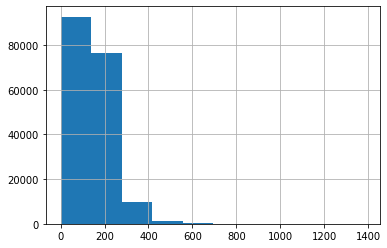

In [ ]:
train_sentences.map(len).hist()

In [ ]:
import string

In [ ]:
chars= string.ascii_lowercase + string.punctuation
chars,len(chars)

('abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', 58)

In [ ]:


chars= string.ascii_lowercase + string.punctuation

TOKEN_NUMS = len(chars)
output_seq_len=int(np.percentile(train_sentences.map(len),95))

char_vectorizer=TextVectorization(max_tokens=TOKEN_NUMS,
                                  output_sequence_length=output_seq_len,
                                  standardize=None)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vectorizer(get_chars(val_sentences[0]))

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([ 4, 18,  2,  9,  2,  6,  9,  4,  3,  4, 32,  5,  3,  4,  7,  6,  3,
        7,  5,  9, 14,  2,  8, 18,  4, 12, 12, 16,  9, 17, 16, 15,  4, 18,
        5,  3, 16,  9,  5,  6, 10,  5, 14,  7,  9,  4,  3,  4, 22,  2,  9,
       14, 16,  3, 16, 15, 17, 16,  6, 18,  5, 12, 11, 16, 12,  3, 16,  8,
        2,  8,  2,  9, 16, 12,  3,  5,  8,  2, 11,  7, 15, 15,  7,  6,  4,
        6, 14,  5,  3,  4,  2,  6,  3,  9, 21,  4,  3, 13,  8,  2, 17,  8,
        5, 11,  3,  7,  8, 20,  5,  9,  3, 13, 15,  5, 25,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [ ]:
char_vocab=char_vectorizer.get_vocabulary()

In [ ]:
char_vocab[:5],char_vocab[-5:]

(['', '[UNK]', 'e', 't', 'i'], ['|', '"', ']', '\\', '['])

In [ ]:
char_vocab

['',
 '[UNK]',
 'e',
 't',
 'i',
 'a',
 'n',
 'o',
 'r',
 's',
 'd',
 'c',
 'l',
 'h',
 'p',
 'm',
 'u',
 'f',
 'g',
 '@',
 'y',
 'w',
 'v',
 'b',
 ',',
 '.',
 '-',
 ')',
 '(',
 'k',
 'x',
 '%',
 'z',
 '=',
 'q',
 '/',
 ';',
 'j',
 ':',
 '<',
 "'",
 '+',
 '`',
 '>',
 '$',
 '&',
 '*',
 '~',
 '?',
 '#',
 '_',
 '!',
 '|',
 '"',
 ']',
 '\\',
 '[']

In [ ]:
char_vectorizer(train_chars[395])

<tf.Tensor: shape=(290,), dtype=int64, numpy=
array([11,  7,  6,  3,  5, 15,  4,  6,  5,  3,  4,  7,  6, 11, 13,  5,  6,
       18,  2, 10,  9,  4, 18,  6,  4, 17,  4, 11,  5,  6,  3, 12, 20,  7,
       22,  2,  8,  3,  4, 15,  2,  4,  6, 11, 13,  5,  6, 10, 21,  5, 30,
       21,  4,  3, 13,  7, 16,  3,  9,  4, 18,  6,  4, 17,  4, 11,  5,  6,
        3, 10,  4, 17, 17,  2,  8,  2,  6, 11,  2, 23,  2,  3, 21,  2,  2,
        6, 18,  8,  7, 16, 14,  9, 25,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

**Char Encoder**

In [ ]:
char_embedding=layers.Embedding(input_dim=TOKEN_NUMS,
                               output_dim=25,
                               mask_zero=True,
                               name='char_embedding')

In [ ]:
random_sentence=random.choice(train_sentences)

In [ ]:
char_embedding(char_vectorizer([random_sentence]))

<tf.Tensor: shape=(1, 290, 25), dtype=float32, numpy=
array([[[ 0.01880281,  0.03706581,  0.04133764, ..., -0.00616445,
          0.02771853,  0.01996816],
        [ 0.01880281,  0.03706581,  0.04133764, ..., -0.00616445,
          0.02771853,  0.01996816],
        [ 0.01880281,  0.03706581,  0.04133764, ..., -0.00616445,
          0.02771853,  0.01996816],
        ...,
        [-0.00418894,  0.02999166,  0.00796962, ...,  0.02498484,
          0.00447784,  0.0488483 ],
        [-0.00418894,  0.02999166,  0.00796962, ...,  0.02498484,
          0.00447784,  0.0488483 ],
        [-0.00418894,  0.02999166,  0.00796962, ...,  0.02498484,
          0.00447784,  0.0488483 ]]], dtype=float32)>

### **Char level dataset**

In [ ]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))


In [ ]:
train_char_dataset=train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

### **model with char embedding**

In [ ]:
input=layers.Input(shape=[],dtype=tf.string)

char_vectors=char_vectorizer(input)
char_embedd=char_embedding(char_vectors)

x=layers.Conv1D(128,kernel_size=5,activation='relu')(char_embedd)
x=layers.GlobalMaxPooling1D()(x)
output=layers.Dense(num_classes,activation='softmax')(x)

model_3=tf.keras.Model(input,output)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 char_embedding (Embedding)  (None, 290, 25)           1450      
                                                                 
 conv1d_1 (Conv1D)           (None, 286, 128)          16128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 645 

In [ ]:
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_3.fit(train_char_dataset,
            epochs=3,
            validation_data=val_char_dataset)

Epoch 1/3
5627/5627 [==============================] - 29s 5ms/step - loss: 0.7552 - accuracy: 0.7089 - val_loss: 0.6443 - val_accuracy: 0.7569
Epoch 2/3
5627/5627 [==============================] - 29s 5ms/step - loss: 0.6213 - accuracy: 0.7672 - val_loss: 0.6093 - val_accuracy: 0.7736
Epoch 3/3
5627/5627 [==============================] - 29s 5ms/step - loss: 0.5905 - accuracy: 0.7797 - val_loss: 0.6008 - val_accuracy: 0.7772


In [ ]:
model_3_pred_probs=model_3.predict(val_char_dataset)

945/945 [==============================] - 2s 2ms/step


In [ ]:
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
model_3_results=evaluate_model(y_true=val_label_encoded,
                               y_preds=model_3_preds)

model_3_results # with Maxpoolong

{'accuracy': 0.777240831457699,
 'recall': 0.777240831457699,
 'precision': 0.7746319620861085,
 'f1-score': 0.7712496495274035}

In [ ]:
model_3_results=evaluate_model(y_true=val_label_encoded,
                               y_preds=model_3_preds)

model_3_results # with globalpoolong

{'accuracy': 0.777240831457699,
 'recall': 0.777240831457699,
 'precision': 0.7746319620861085,
 'f1-score': 0.7712496495274035}

## **Model 4 : Combined pre-trained token embedding ➕ chararacter embedding**

### **make hybrid dataset ( word + char )**

In [ ]:
train_word_char_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
val_word_char_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
test_word_char_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))

train_word_char_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
val_word_char_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
test_word_char_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot))


In [ ]:
train_word_char_dataset=tf.data.Dataset.zip((train_word_char_data,train_word_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_word_char_dataset=tf.data.Dataset.zip((val_word_char_data,val_word_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_word_char_dataset=tf.data.Dataset.zip((test_word_char_data,test_word_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

### **Hybrid model**

Steps :

1. make a token-level embedding model `model_2`
2. make a char-level embedding modle `model_3`
3. Combined both models
4. Build a model:-
* input ➡ token and character level sequences
* output ➡ output sequence label probablities

In [ ]:
# make a token_level embedding model

word_input=layers.Input(shape=[],dtype=tf.string)
# word_vectors=word_vectorizer(word_input)
word_embedd=word_embedding_layer(word_input)

word_outputs=layers.Dense(128,activation='relu')(word_embedd)
word_model=tf.keras.Model(inputs=word_input,
                          outputs=word_outputs)


# make a char enmbedding model

char_input=layers.Input(shape=[],dtype=tf.string)
char_vectors=char_vectorizer(char_input)
char_embedd=char_embedding(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embedd)
char_model=tf.keras.Model(inputs=char_input,
                          outputs=char_bi_lstm)

# combine both models
combined_embeddings=layers.Concatenate(name='combine_word_char_model')([word_model.output,
                                       char_model.output])

# hybrid model

combined_dropout=layers.Dropout(0.5)(combined_embeddings)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

model_4=tf.keras.Model(inputs=[word_model.input,char_model.input],
                       outputs=output_layer,
                       name='hybrid_word_char_model')

model_4.summary()

Model: "hybrid_word_char_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['input_5[0][0]']                
 orization)                                                                                       
                                                                                                  
 use (KerasLayer)               (None, 512)          256797824   ['input_4[0]

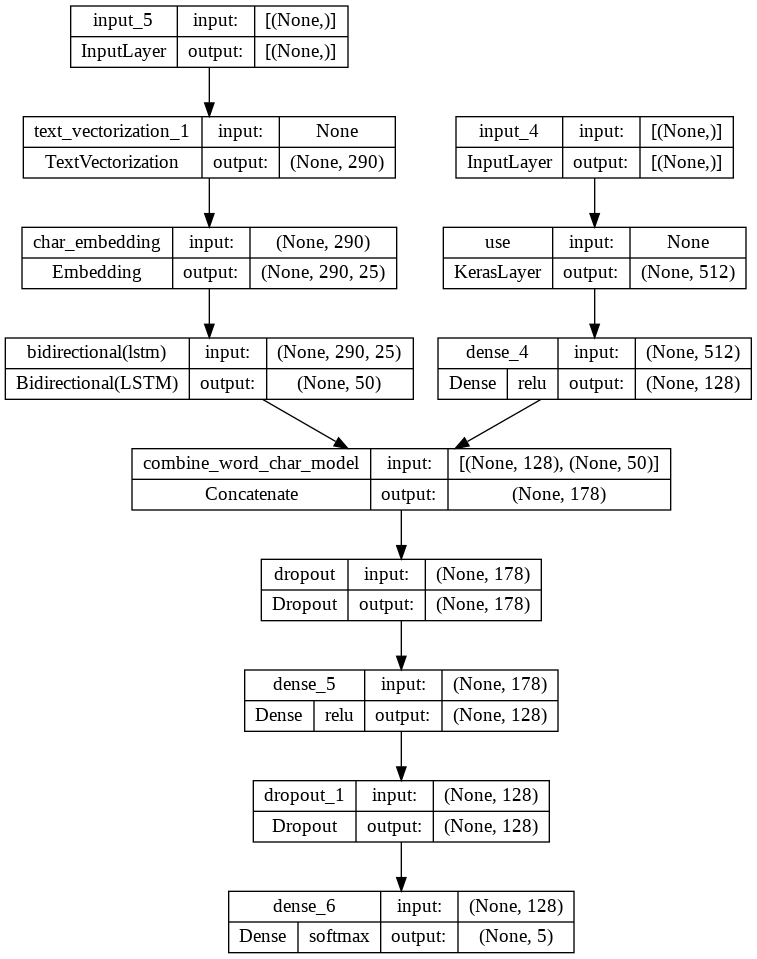

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_4,
           show_shapes=True,
           show_layer_activations=True)

In [ ]:
model_4.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
model_4.fit(train_word_char_dataset,
            epochs=3,
            validation_data=val_word_char_dataset)

Epoch 1/3
5627/5627 [==============================] - 237s 41ms/step - loss: 0.7509 - accuracy: 0.7150 - val_loss: 0.6082 - val_accuracy: 0.7721
Epoch 2/3
5627/5627 [==============================] - 229s 41ms/step - loss: 0.6570 - accuracy: 0.7560 - val_loss: 0.5818 - val_accuracy: 0.7817
Epoch 3/3
5627/5627 [==============================] - 226s 40ms/step - loss: 0.6293 - accuracy: 0.7672 - val_loss: 0.5553 - val_accuracy: 0.7897


In [ ]:
model_4_pred_probs=model_4.predict(val_word_char_dataset)

945/945 [==============================] - 23s 22ms/step


In [ ]:
model_4_preds=tf.argmax(model_4_pred_probs,axis=1)

In [ ]:
model_4_results=evaluate_model(y_true=val_label_encoded,
                               y_preds=model_4_preds)

In [ ]:
model_4_results

{'accuracy': 0.7896531179663709,
 'recall': 0.7896531179663709,
 'precision': 0.7881832748200681,
 'f1-score': 0.7856177681124873}

## **Model 5 : Pretrain word embedding ➕ char embedding ➕ positional embedding**



Here `positional embedding` means that we are going to pass the postion of a sentence. wheter it is placed in starting,middle or bottom.

In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


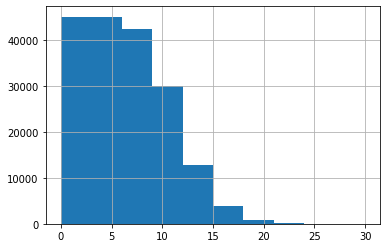

In [ ]:
train_df.line_number.hist()

In [ ]:
train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)


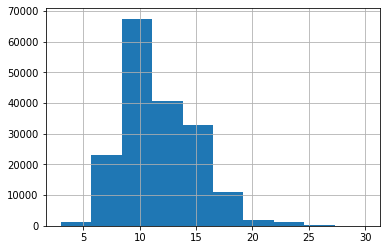

In [ ]:
train_df['total_lines'].hist()

In [ ]:
train_total_line_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_line_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_line_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

In [ ]:
train_total_line_one_hot.shape,train_sentences.shape,train_line_numbers_one_hot.shape

(TensorShape([180040, 20]), (180040,), TensorShape([180040, 15]))

In [ ]:
#@title try it later


train_line_numbers,train_total_lines=train_df['line_number'],train_df['total_lines']
val_line_numbers,val_total_lines=val_df['line_number'],val_df['total_lines']
test_line_numbers,test_total_lines=test_df['line_number'],test_df['total_lines']

train_positional_data=tf.data.Dataset.from_tensor_slices((train_line_numbers,train_total_lines))
val_positional_data=tf.data.Dataset.from_tensor_slices((val_line_numbers,val_total_lines))
test_positional_data=tf.data.Dataset.from_tensor_slices((test_line_numbers,test_total_lines))

### **word+char+position embedding**

In [ ]:
train_word_char_position_data=tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                  train_chars,
                                                                  train_line_numbers_one_hot,
                                                                  train_total_line_one_hot))

val_word_char_position_data=tf.data.Dataset.from_tensor_slices((val_sentences,
                                                                val_chars,
                                                                val_line_numbers_one_hot,
                                                                val_total_line_one_hot))

test_word_char_position_data=tf.data.Dataset.from_tensor_slices((test_sentences,
                                                                 test_chars,
                                                                 test_line_numbers_one_hot,
                                                                 test_total_line_one_hot))

train_word_char_position_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
val_word_char_position_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
test_word_char_position_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot))


In [ ]:
train_word_char_position_dataset=tf.data.Dataset.zip((train_word_char_position_data,
                                                      train_word_char_position_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_word_char_position_dataset=tf.data.Dataset.zip((val_word_char_position_data,
                                                    val_word_char_position_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_word_char_position_dataset=tf.data.Dataset.zip((test_word_char_position_data,
                                                     test_word_char_position_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

### **Tribrid model**

Steps: 

1. create model for `word` embedding `model_2`
2. create model for `char` embedding `model_3`
3. create model for `line_number` embedding `line_model`
4. create model for `total_lines` embedding `total_line_model`
5. conatenate `model_2` and `model_3` as `word_char_model`
6. concatenate `line_model` and `total_line_model` as `word_char_model`
7. create a `tribrid model` 

In [ ]:
num_classes=len(train_df['target'].value_counts())
num_classes

5

In [ ]:
# 1. make a token_level embedding model

word_input=layers.Input(shape=[],dtype=tf.string)
# word_vectors=word_vectorizer(word_input)
word_embedd=word_embedding_layer(word_input)

word_outputs=layers.Dense(128,activation='relu')(word_embedd)
word_model=tf.keras.Model(inputs=word_input,
                          outputs=word_outputs)


# 2. make a char enmbedding model

char_input=layers.Input(shape=[],dtype=tf.string)
char_vectors=char_vectorizer(char_input)
char_embedd=char_embedding(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embedd)
char_model=tf.keras.Model(inputs=char_input,
                          outputs=char_bi_lstm)

# 3. make a line number embedding model

line_input=layers.Input(shape=(15,),dtype=tf.float32)
line_dense=layers.Dense(32,activation='relu')(line_input)
line_model=tf.keras.Model(inputs=line_input,
                          outputs=line_dense)

# 4. make a total lines embedding model

total_line_input=layers.Input(shape=(20,),dtype=tf.float32)
total_line_dense=layers.Dense(32,activation='relu')(total_line_input)
total_line_model=tf.keras.Model(inputs=total_line_input,
                                outputs=total_line_dense)

# 5. combine word_model & char_model
combined_word_char_embeddings=layers.Concatenate(name='combine_word_char_model')([word_model.output,
                                       char_model.output])

z=layers.Dense(25,activation='relu')(combined_word_char_embeddings)
z=layers.Dropout(0.5)(z)


# 6. combine word_char_embeddings and line_model & total_line_model

final_combined_embeddings=layers.Concatenate(name='combine_word_char_model_with_positional_models')([z,
                                                                                                    line_model.output,
                                                                                                    total_line_model.output])

# tribrid model

combined_dropout=layers.Dropout(0.5)(final_combined_embeddings)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

model_5=tf.keras.Model(inputs=[word_model.input,
                               char_model.input,
                               line_model.input,
                               total_line_model.input],
                       outputs=output_layer,
                       name='tribrid_word_char_positional_model')

model_5.summary()

Model: "tribrid_word_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_2 (TextVect  (None, 290)         0           ['input_6[0][0]']                
 orization)                                                                                       
                                                                                                  
 use (KerasLayer)               (None, 512)          256797824   

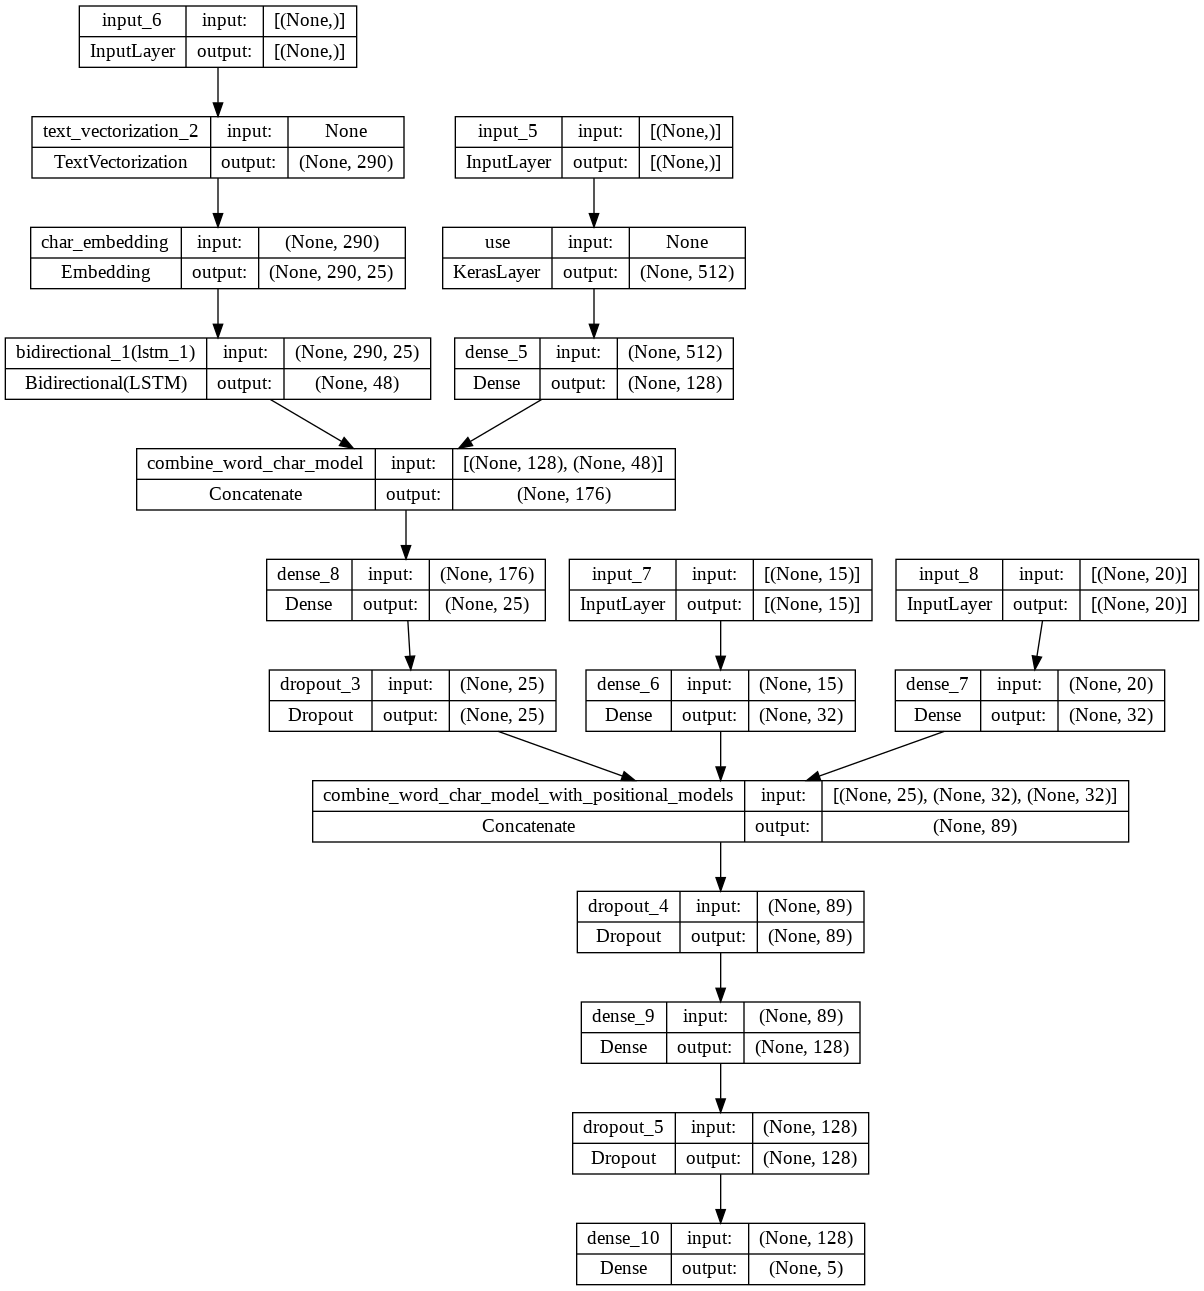

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
    )

In [ ]:
model_5.fit(train_word_char_position_dataset,
            epochs=3,
            steps_per_epoch=int(0.1*len(train_word_char_position_dataset)),
            validation_data=val_word_char_position_dataset,
            validation_steps=int(0.1*len(val_word_char_position_dataset))
            )

Epoch 1/3
562/562 [==============================] - 201s 336ms/step - loss: 1.2529 - accuracy: 0.5977 - val_loss: 1.0324 - val_accuracy: 0.7550
Epoch 2/3
562/562 [==============================] - 178s 316ms/step - loss: 1.1075 - accuracy: 0.7146 - val_loss: 0.9996 - val_accuracy: 0.7902
Epoch 3/3
562/562 [==============================] - 174s 309ms/step - loss: 1.0740 - accuracy: 0.7381 - val_loss: 0.9818 - val_accuracy: 0.7965


In [ ]:
model_5_pred_probs=model_5.predict(val_word_char_position_dataset)

945/945 [==============================] - 82s 83ms/step


In [ ]:
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)

In [ ]:
model_5_results=evaluate_model(y_true=val_label_encoded,
                               y_preds=model_5_preds)

model_5_results

{'accuracy': 0.7972328875943334,
 'recall': 0.7972328875943334,
 'precision': 0.792167400880348,
 'f1-score': 0.7921763020704417}

## **Final Blow - PubMed200 Replication** 

In [ ]:
# get data

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

data_dir='/content/pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
# libraries
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
import string

In [ ]:
# helper functions

def evaluate_model(y_true,y_preds):
  '''
    make a function to evaluate model experiments
  '''
  model_accuracy=accuracy_score(y_true,y_preds)
  model_recall=recall_score(y_true,y_preds,average='weighted')
  model_precision=precision_score(y_true,y_preds,average='weighted')
  model_f1=f1_score(y_true,y_preds,average='weighted')

  return {
      "accuracy":model_accuracy,
      "recall":model_recall,
      "precision":model_precision,
      "f1-score":model_f1
  }


def get_chars(lines):
  '''
    takes sentneces and convert it into character level ...
  '''
  return ' '.join(list(lines))

  
def get_lines(filename):
  """
    reads a text file and return all lines in a list.
  """

  with open (filename,'r') as file:
    return file.readlines()

# here we are going to write a preprcessing function to do so...

def preprocessing_text_with_line_number(filename):
  """
    Takes a filename and extract all lines then make a list of dictionaries,
    For each instance each one contains :
        line_number
        target
        text
        total_lines = number of lines in each paragraph
  """

  input_lines = get_lines(data_dir + filename)
  text_blog=""

  samples=[]

  for line in input_lines:

    if line.startswith('###'):
      id=line
      text_blog=""
    elif line.isspace():

      all_lines=text_blog.splitlines()

      for line_number,curr_line in enumerate(all_lines):
        temp=dict()
        temp['line_number']=line_number
        label,text=curr_line.split('\t')
        temp['target']=label
        temp['text']=text.lower()
        temp['total_lines']=len(all_lines)-1

        samples.append(temp)

    else:
      text_blog+=line 

  return samples 




In [ ]:
# read text from files in list of dicitionaries as well structured

train_text=preprocessing_text_with_line_number('train.txt')
val_text=preprocessing_text_with_line_number('dev.txt')
test_text=preprocessing_text_with_line_number('test.txt')

# load into dataframe

train_df=pd.DataFrame(train_text)
val_df=pd.DataFrame(val_text)
test_df=pd.DataFrame(test_text)

# OnehotEncoding 

one_hot_encoder=OneHotEncoder(sparse=False)

train_labels_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1,1))

# LabelEncoding

label_encoder=LabelEncoder()

train_label_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
test_label_encoded=label_encoder.transform(test_df['target'].to_numpy())
val_label_encoded=label_encoder.transform(val_df['target'].to_numpy())


In [ ]:
# sentences
train_sentences=train_df['text']
test_sentences=test_df['text']
val_sentences=val_df['text']


In [ ]:
# word vectorizer & embedding

output_seq_len=np.percentile(train_sentences.map(lambda x : len(x.split())),95)

max_vocab_length=68000
max_length=int(output_seq_len)
word_vectorizer=TextVectorization(max_tokens=max_vocab_length,
                                  output_mode='int',
                                  output_sequence_length=max_length,
                                  name='word_vectorizer')

word_embedding=tf.keras.layers.Embedding(
    input_dim=max_vocab_length,
    output_dim=128,
    mask_zero=True,
    name='word_embedding'
)

word_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      name='use')



In [ ]:
# convert sentence data into tensor dataset - batch & prefetech

train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))

train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#train_chars

train_chars=[get_chars(line) for line in train_sentences]
test_chars=[get_chars(line) for line in test_sentences]
val_chars=[get_chars(line) for line in val_sentences]

In [ ]:
# char vectorizer and embedding

chars= string.ascii_lowercase + string.punctuation

TOKEN_NUMS = len(chars)
output_seq_len=int(np.percentile(train_sentences.map(len),95))

char_vectorizer=TextVectorization(max_tokens=TOKEN_NUMS,
                                  output_sequence_length=output_seq_len,
                                  standardize=None,
                                  name='char_vectorizer')

char_embedding=layers.Embedding(input_dim=TOKEN_NUMS,
                               output_dim=25,
                               mask_zero=True,
                               name='char_embedding')

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
# convert char data into tensor dataset - batch & prefetech

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot))
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot))
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot))

train_char_dataset=train_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=val_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=test_char_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# combine word and char data into tensor dataset

train_word_char_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars))
val_word_char_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars))
test_word_char_data=tf.data.Dataset.from_tensor_slices((test_sentences,test_chars))

train_word_char_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
val_word_char_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
test_word_char_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot))

train_word_char_dataset=tf.data.Dataset.zip((train_word_char_data,train_word_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_word_char_dataset=tf.data.Dataset.zip((val_word_char_data,val_word_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_word_char_dataset=tf.data.Dataset.zip((test_word_char_data,test_word_char_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# positional data

train_line_numbers_one_hot=tf.one_hot(train_df['line_number'].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df['line_number'].to_numpy(),depth=15)

train_total_line_one_hot=tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
val_total_line_one_hot=tf.one_hot(val_df['total_lines'].to_numpy(),depth=20)
test_total_line_one_hot=tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)



In [ ]:
# combining word,char and positional data into tensor dataset

train_word_char_position_data=tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                  train_chars,
                                                                  train_line_numbers_one_hot,
                                                                  train_total_line_one_hot))

val_word_char_position_data=tf.data.Dataset.from_tensor_slices((val_sentences,
                                                                val_chars,
                                                                val_line_numbers_one_hot,
                                                                val_total_line_one_hot))

test_word_char_position_data=tf.data.Dataset.from_tensor_slices((test_sentences,
                                                                 test_chars,
                                                                 test_line_numbers_one_hot,
                                                                 test_total_line_one_hot))

train_word_char_position_labels=tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
val_word_char_position_labels=tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
test_word_char_position_labels=tf.data.Dataset.from_tensor_slices((test_labels_one_hot))


train_word_char_position_dataset=tf.data.Dataset.zip((train_word_char_position_data,
                                                      train_word_char_position_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
val_word_char_position_dataset=tf.data.Dataset.zip((val_word_char_position_data,
                                                    val_word_char_position_labels)).batch(32).prefetch(tf.data.AUTOTUNE)
test_word_char_position_dataset=tf.data.Dataset.zip((test_word_char_position_data,
                                                     test_word_char_position_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1. make a token_level embedding model

word_input=layers.Input(shape=[],dtype=tf.string)
# word_vectors=word_vectorizer(word_input)
word_embedd=word_embedding_layer(word_input)

word_outputs=layers.Dense(128,activation='relu')(word_embedd)
word_model=tf.keras.Model(inputs=word_input,
                          outputs=word_outputs)

# 2. make a char embedding model

char_input=layers.Input(shape=[],dtype=tf.string)
char_vectors=char_vectorizer(char_input)
char_embedd=char_embedding(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embedd)
char_model=tf.keras.Model(inputs=char_input,
                          outputs=char_bi_lstm)

# 3. make a line number embedding model

line_input=layers.Input(shape=(15,),dtype=tf.float32)
line_dense=layers.Dense(32,activation='relu')(line_input)
line_model=tf.keras.Model(inputs=line_input,
                          outputs=line_dense)

# 4. make a total lines embedding model

total_line_input=layers.Input(shape=(20,),dtype=tf.float32)
total_line_dense=layers.Dense(32,activation='relu')(total_line_input)
total_line_model=tf.keras.Model(inputs=total_line_input,
                                outputs=total_line_dense)

# 5. combine word_model & char_model
combined_word_char_embeddings=layers.Concatenate(name='combine_word_char_model')([word_model.output,
                                       char_model.output])

z=layers.Dense(25,activation='relu')(combined_word_char_embeddings)
z=layers.Dropout(0.5)(z)


# 6. combine word_char_embeddings and line_model & total_line_model

final_combined_embeddings=layers.Concatenate(name='combine_word_char_model_with_positional_models')([z,
                                                                                                    line_model.output,
                                                                                                    total_line_model.output])

# tribrid model

combined_dropout=layers.Dropout(0.5)(final_combined_embeddings)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

model=tf.keras.Model(inputs=[word_model.input,
                               char_model.input,
                               line_model.input,
                               total_line_model.input],
                       outputs=output_layer,
                       name='tribrid_word_char_positional_model')

model.summary()

Model: "tribrid_word_char_positional_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_18[0][0]']               
 tion)                                                                                            
                                                                                                  
 use (KerasLayer)               (None, 512)          256797824   

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(train_word_char_position_dataset,
          epochs=3,
          validation_data=val_word_char_position_dataset)

Epoch 1/3
5627/5627 [==============================] - 1687s 298ms/step - loss: 1.0628 - accuracy: 0.7381 - val_loss: 0.9284 - val_accuracy: 0.8247
Epoch 2/3
5627/5627 [==============================] - 1709s 304ms/step - loss: 0.9856 - accuracy: 0.7907 - val_loss: 0.9090 - val_accuracy: 0.8366
Epoch 3/3
5627/5627 [==============================] - 1720s 306ms/step - loss: 0.9688 - accuracy: 0.8036 - val_loss: 0.9066 - val_accuracy: 0.8422


In [ ]:
model_pred_probs=model.predict(val_word_char_position_dataset)
model_preds=tf.argmax(model_pred_probs,axis=1)

945/945 [==============================] - 106s 108ms/step


In [ ]:
model_results=evaluate_model(y_true=val_label_encoded,
                             y_preds=model_preds)


In [ ]:
model_results

{'accuracy': 0.842181914471071,
 'recall': 0.842181914471071,
 'precision': 0.846911794134533,
 'f1-score': 0.8329869744539251}